In [2]:
import pandas as pd
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import numpy as np
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
from keras.models import Model, Sequential
import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import *
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D

Using TensorFlow backend.


In [20]:
data = pd.read_csv("clean.csv")

In [5]:
vocabulary = {}
inverse_vocabulary = ['<unk>']

In [6]:
data.head()

diposisi  \
0  Dinas Perumahan dan Kawasan Permukiman Kota Se...   
1              Kanwil Kementerian Hukum dan HAM Aceh   
2                           BPJS Kesehatan KCU Medan   
3                       Direktorat Jenderal Imigrasi   
4                       BPJS Kesehatan KC Banda Aceh   

                                               judul  \
0  Sebagian pju dijalan durian raya pedalangan ba...   
1  Mempertanyakan kelulusan SKD tapi tidak Capai ...   
2                              peralihan kepesertaan   
3       Pelayanan Imigrasi Online Tidak Bisa Diakses   
4           Pindah layanan Kesehatan Tingkat Pertama   

                                             keluhan  \
0  Sebagian pju dijalan durian raya pedalangan ba...   
1  saya kecewa kelulusan SKD tak sesuai keputusan...   
2  0001125348254 Ingin beralih dari medan sehat k...   
3  mau tanya untuk pelayanan imigrasi online suda...   
4            bagaiana proses untuk pindah puskesmas?   

                                                tipe  \
0                                      Topik Lainnya   
1                                        Kepegawaian   
2  Permintaan Informasi Tentang Perubahan Jenis K...   
3                                           Imigrasi   
4  Permintaan Informasi Tentang Perubahan Data Pe...   

                                               clean  
0  pju dijalan durian raya dalang banyumanik mati...  
1  kecewa lulus skd suai putus menteri aceh capai...  
2                          alih medan sehat tanggung  
3               layan imigrasi online minggu diakses  
4                   bagaiana proses pindah puskesmas

In [7]:
def text_to_word_list(text):
    text = str(text)
    text = text.lower()
    text = text.split()

    return text

In [8]:
def load_embed(nomor):
    if nomor ==1:
        glove2word2vec(glove_input_file="./vectors_50d.txt", word2vec_output_file="gensim_glove_vectors.txt")
        word2vec = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)
    if nomor == 2:
        glove2word2vec(glove_input_file="./vectors_100d.txt", word2vec_output_file="gensim_glove_vectors.txt")
        word2vec = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)
    if nomor == 3:
        glove2word2vec(glove_input_file="./vectors.txt", word2vec_output_file="gensim_glove_vectors.txt")
        word2vec = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)
    return word2vec

In [53]:
label = data['tipe'].unique().tolist()
label

['Topik Lainnya',
 'Kepegawaian',
 'Permintaan Informasi Tentang Perubahan Jenis Kepesertaan',
 'Imigrasi',
 'Permintaan Informasi Tentang Perubahan Data Peserta (Faskes Tk 1, Data peserta)',
 'Kesehatan',
 'Permintaan Informasi Tentang Besaran Iuran',
 'Infrastruktur',
 'Lain-lain',
 'Permintaan Informasi Tentang Mekanisme Penonaktifan Peserta Meninggal',
 'Permintaan Informasi Cek Pembayaran Iuran',
 'Permintaan Informasi Tentang Pendaftaran PBPU dan BP Online',
 'BPJS Kesehatan',
 'Administrasi Kependudukan',
 'Kartu Indonesia Pintar (KIP)',
 'Perhubungan',
 'Permintaan Informasi Pengecekan Status Kepesertaan',
 'Pendidikan',
 'Pelayanan Administrasi',
 'Reformasi Birokrasi dan Tata Kelola',
 'Bantuan Siswa Miskin (BSM)',
 'Beras Miskin (Raskin)',
 'Bantuan Langsung Sementara Masyarakat (BLSM)',
 'Data peserta tidak sesuai (Nama/TTL/NIK/Alamat/Faskes Tk.I)',
 'Kepesertaan Non-KPS']

In [54]:
data.tipe.value_counts()

Bantuan Langsung Sementara Masyarakat (BLSM)                                       11439
BPJS Kesehatan                                                                      8323
Topik Lainnya                                                                       7853
Infrastruktur                                                                       6370
Bantuan Siswa Miskin (BSM)                                                          5495
Beras Miskin (Raskin)                                                               5012
Kepegawaian                                                                         4709
Kartu Indonesia Pintar (KIP)                                                        3907
Permintaan Informasi Tentang Perubahan Data Peserta (Faskes Tk 1, Data peserta)     3712
Perhubungan                                                                         3444
Kepesertaan Non-KPS                                                                 3385
Permintaan Informasi 

In [18]:
def make_embed (word2vec,data):
    outside_words=set()
    for index,row in (data.iterrows()):
        for question in ['clean']:
            q2n = [] 
            for word in text_to_word_list(row[question]):        
                if word not in word2vec.vocab:
                    outside_words.add(word)
                    continue 
                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word]) 
            data.set_value(index,question,q2n)
    embedding_dim = 50
    embeddings = 1 * np.random.randn(len(vocabulary)+1, embedding_dim)
    embeddings[0] = 0
    for word, index in tqdm(vocabulary.items()):
        if word in word2vec.vocab:
            embeddings[index] = word2vec.word_vec(word)
    return data,embeddings,outside_words

In [10]:
def maketoint(sentence):
    q2n = [] 
    for word in text_to_word_list(sentence):        
        if word in vocabulary:
            q2n.append(vocabulary[word]) 
    return q2n

In [11]:
word = load_embed(1)

In [21]:
data,embed,slang=make_embed(word,data)

/home/ntil/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()
100%|██████████| 15997/15997 [00:00<00:00, 207425.31it/s]


In [22]:
data.head()

diposisi  \
0  Dinas Perumahan dan Kawasan Permukiman Kota Se...   
1              Kanwil Kementerian Hukum dan HAM Aceh   
2                           BPJS Kesehatan KCU Medan   
3                       Direktorat Jenderal Imigrasi   
4                       BPJS Kesehatan KC Banda Aceh   

                                               judul  \
0  Sebagian pju dijalan durian raya pedalangan ba...   
1  Mempertanyakan kelulusan SKD tapi tidak Capai ...   
2                              peralihan kepesertaan   
3       Pelayanan Imigrasi Online Tidak Bisa Diakses   
4           Pindah layanan Kesehatan Tingkat Pertama   

                                             keluhan  \
0  Sebagian pju dijalan durian raya pedalangan ba...   
1  saya kecewa kelulusan SKD tak sesuai keputusan...   
2  0001125348254 Ingin beralih dari medan sehat k...   
3  mau tanya untuk pelayanan imigrasi online suda...   
4            bagaiana proses untuk pindah puskesmas?   

                                                tipe  \
0                                      Topik Lainnya   
1                                        Kepegawaian   
2  Permintaan Informasi Tentang Perubahan Jenis K...   
3                                           Imigrasi   
4  Permintaan Informasi Tentang Perubahan Data Pe...   

                                               clean  
0                        [1, 2, 3, 4, 5, 6, 7, 8, 9]  
1  [10, 11, 12, 13, 14, 15, 16, 17, 18, 11, 16, 1...  
2                                   [24, 25, 26, 27]  
3                               [28, 29, 30, 31, 32]  
4                                       [33, 34, 35]

In [23]:
max_seq_length =data.clean.map(lambda x:len(x)).max()
avegrage = data.clean.map(lambda x:len(x)).mean()
print(max_seq_length)
print(avegrage)

36
9.483609891003741


In [24]:
X = pad_sequences(data.clean, 36)
print (X[0])
Y1 = pd.get_dummies(data['tipe'])
Y = Y1.values
print (Y[0])
column = Y1.columns
column = column.tolist()
print(column)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 6 7 8 9]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
['Administrasi Kependudukan', 'BPJS Kesehatan', 'Bantuan Langsung Sementara Masyarakat (BLSM)', 'Bantuan Siswa Miskin (BSM)', 'Beras Miskin (Raskin)', 'Data peserta tidak sesuai (Nama/TTL/NIK/Alamat/Faskes Tk.I)', 'Imigrasi', 'Infrastruktur', 'Kartu Indonesia Pintar (KIP)', 'Kepegawaian', 'Kepesertaan Non-KPS', 'Kesehatan', 'Lain-lain', 'Pelayanan Administrasi', 'Pendidikan', 'Perhubungan', 'Permintaan Informasi Cek Pembayaran Iuran', 'Permintaan Informasi Pengecekan Status Kepesertaan', 'Permintaan Informasi Tentang Besaran Iuran', 'Permintaan Informasi Tentang Mekanisme Penonaktifan Peserta Meninggal', 'Permintaan Informasi Tentang Pendaftaran PBPU dan BP Online', 'Permintaan Informasi Tentang Perubahan Data Peserta (Faskes Tk 1, Data peserta)', 'Permintaan Informasi Tentang Perubahan Jenis Kepesertaan', 'Reformasi Birokrasi dan Tata Kelola', 'Topik Lainnya']


In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(68846, 36) (68846, 25)
(29506, 36) (29506, 25)


In [117]:
EMBEDDING_DIM =400
embedding_dim=400
MAX_SEQUENCE_LENGTH = 36
filter_sizes = [3,4,5]
num_filters = 512
drop = 0.5
batch_size = 30
epochs = 4
embedding_layer = Embedding(len(vocabulary) + 1,
                            EMBEDDING_DIM,
                            weights=[embed],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = embedding_layer(inputs)

print(embedding.shape)
reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedding)
print(reshape.shape)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=25, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

checkpoint = ModelCheckpoint('weights_cnn_sentece.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

(?, 36, 400)
(?, 36, 400, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 36)           0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 36, 400)      6399200     input_7[0][0]                    
__________________________________________________________________________________________________
reshape_7 (Reshape)             (None, 36, 400, 1)   0           embedding_7[0][0]                
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 34, 1, 512)   614912      reshape_7[0][0]                  
________________________________________________________________________________

# Menggunakan 50 Dimensi Glove

In [89]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 61961 samples, validate on 6885 samples
Epoch 1/4
61961/61961 [==============================] - 26s 427us/step - loss: 0.1122 - acc: 0.9652 - val_loss: 0.0830 - val_acc: 0.9711
Epoch 2/4
61961/61961 [==============================] - 26s 413us/step - loss: 0.0832 - acc: 0.9713 - val_loss: 0.0741 - val_acc: 0.9741
Epoch 3/4
61961/61961 [==============================] - 25s 410us/step - loss: 0.0750 - acc: 0.9737 - val_loss: 0.0698 - val_acc: 0.9756
Epoch 4/4
61961/61961 [==============================] - 26s 420us/step - loss: 0.0702 - acc: 0.9750 - val_loss: 0.0676 - val_acc: 0.9763


In [90]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 97.58%


In [91]:
scores = model.evaluate(X_train, Y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 97.75%


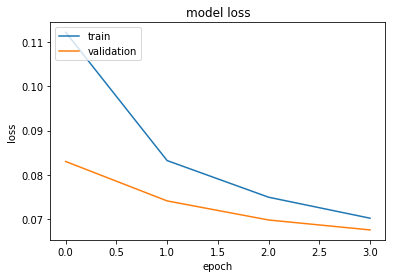

In [92]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Menggunakan 50 Dimensi Glove (tanpa pre)

In [18]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Instructions for updating:
Use tf.cast instead.
Train on 61961 samples, validate on 6885 samples
Epoch 1/4
61961/61961 [==============================] - 33s 528us/step - loss: 0.1207 - acc: 0.9637 - val_loss: 0.0883 - val_acc: 0.9692
Epoch 2/4
61961/61961 [==============================] - 31s 505us/step - loss: 0.0874 - acc: 0.9700 - val_loss: 0.0764 - val_acc: 0.9729
Epoch 3/4
61961/61961 [==============================] - 31s 508us/step - loss: 0.0775 - acc: 0.9727 - val_loss: 0.0711 - val_acc: 0.9747
Epoch 4/4
61961/61961 [==============================] - 31s 506us/step - loss: 0.0723 - acc: 0.9742 - val_loss: 0.0684 - val_acc: 0.9756


In [19]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 97.53%


In [20]:
scores = model.evaluate(X_train, Y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 97.69%


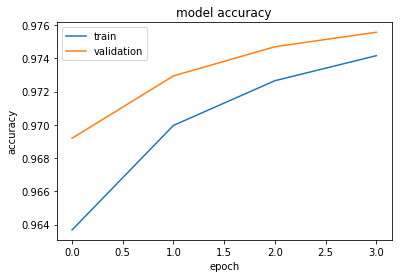

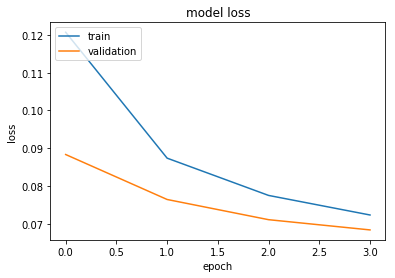

In [21]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [93]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_cnn_50_pre.h5")
print("Saved model to disk")

Saved model to disk


In [22]:
new_complaint = "bis membuat jalan macet"
pad = maketoint(new_complaint)
pad=[pad]
padded = pad_sequences(pad, maxlen=53)
pred = model.predict(padded)
print(pred, column[np.argmax(pred)])

[[2.9435265e-03 4.7171600e-03 2.2254402e-03 1.0145858e-03 6.7219301e-04
  4.0376585e-04 4.2186952e-03 2.1433571e-01 1.2553226e-03 1.1668270e-03
  1.6227181e-03 5.6500859e-03 6.2197372e-02 3.7216206e-04 1.4300116e-03
  5.5193704e-01 9.5959113e-04 1.7741800e-04 8.6622831e-04 9.1478287e-04
  2.9569244e-04 2.8293529e-03 3.3767897e-04 3.8166881e-02 9.9289805e-02]] Perhubungan


In [24]:
new_complaint = "jalan di keputih ada lubang"
pad = maketoint(new_complaint)
pad=[pad]
padded = pad_sequences(pad, maxlen=53)
pred = model.predict(padded)
print(pred, column[np.argmax(pred)])

[[8.0556521e-04 6.1457709e-04 7.0593110e-04 6.6026242e-04 3.7869046e-04
  2.6814468e-04 3.7289836e-04 7.2931743e-01 6.2012390e-05 3.1647185e-04
  4.8334789e-04 1.9879036e-03 4.5783684e-02 6.4614302e-05 5.9356360e-04
  1.2341386e-01 7.0507354e-05 5.1998428e-05 8.5729778e-05 2.7612550e-05
  1.0910045e-04 9.9682761e-04 7.1431808e-05 2.2129159e-02 7.0628770e-02]] Infrastruktur


In [23]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_cnn_50.h5")
print("Saved model to disk")

Saved model to disk


# Menggunakan 100 Dimensi Glove

In [103]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 61961 samples, validate on 6885 samples
Epoch 1/4
61961/61961 [==============================] - 31s 500us/step - loss: 0.1070 - acc: 0.9663 - val_loss: 0.0769 - val_acc: 0.9731
Epoch 2/4
61961/61961 [==============================] - 29s 474us/step - loss: 0.0773 - acc: 0.9730 - val_loss: 0.0687 - val_acc: 0.9755
Epoch 3/4
61961/61961 [==============================] - 30s 481us/step - loss: 0.0691 - acc: 0.9754 - val_loss: 0.0662 - val_acc: 0.9763
Epoch 4/4
61961/61961 [==============================] - 30s 477us/step - loss: 0.0646 - acc: 0.9767 - val_loss: 0.0637 - val_acc: 0.9770


In [104]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 97.67%


In [105]:
scores = model.evaluate(X_train, Y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 97.94%


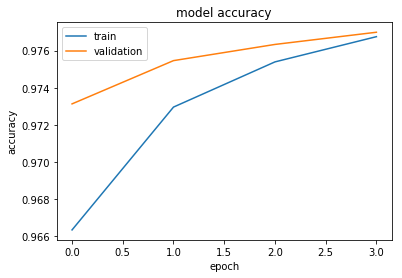

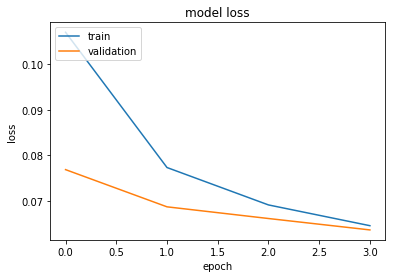

In [106]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [107]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_cnn_100_pre.h5")
print("Saved model to disk")

Saved model to disk


# Menggunakan 100 Dimensi Glove (tanpa pre)

In [39]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 61961 samples, validate on 6885 samples
Epoch 1/4
61961/61961 [==============================] - 38s 607us/step - loss: 0.1148 - acc: 0.9648 - val_loss: 0.0810 - val_acc: 0.9719
Epoch 2/4
61961/61961 [==============================] - 37s 591us/step - loss: 0.0808 - acc: 0.9718 - val_loss: 0.0710 - val_acc: 0.9748
Epoch 3/4
61961/61961 [==============================] - 37s 593us/step - loss: 0.0715 - acc: 0.9746 - val_loss: 0.0668 - val_acc: 0.9760
Epoch 4/4
61961/61961 [==============================] - 36s 587us/step - loss: 0.0664 - acc: 0.9761 - val_loss: 0.0643 - val_acc: 0.9767


In [40]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 97.64%


In [41]:
scores = model.evaluate(X_train, Y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 97.88%


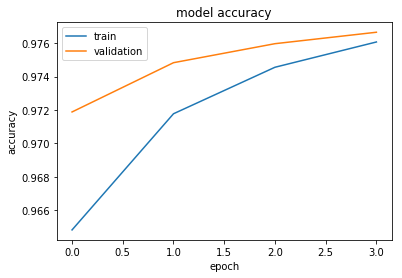

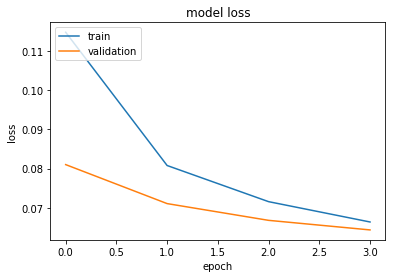

In [42]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [43]:
new_complaint = "bis membuat jalan macet"
pad = maketoint(new_complaint)
pad=[pad]
padded = pad_sequences(pad, maxlen=53)
pred = model.predict(padded)
print(pred, column[np.argmax(pred)])

[[0.00365674 0.0142145  0.00075213 0.00053811 0.00046481 0.00057566
  0.00339189 0.32900298 0.00058127 0.00189572 0.00049046 0.01036841
  0.05617003 0.00153799 0.00123855 0.41683128 0.0028174  0.00074885
  0.00233435 0.00227278 0.00128458 0.00301787 0.00153467 0.04678707
  0.09749196]] Perhubungan


In [46]:
new_complaint = "aspal berlubang di keputih"
pad = maketoint(new_complaint)
pad=[pad]
padded = pad_sequences(pad, maxlen=53)
pred = model.predict(padded)
print(pred, column[np.argmax(pred)])

[[4.4628259e-04 6.1177602e-04 9.3187130e-04 4.1750327e-04 2.6364924e-04
  1.1640678e-04 1.6202159e-04 9.1520220e-01 1.5810123e-04 1.3501865e-04
  2.7151738e-04 1.3853229e-03 3.5782427e-02 6.9106805e-05 3.2774240e-04
  1.6210143e-02 1.9551626e-04 5.2019292e-05 8.4379448e-05 2.6185544e-05
  4.5226057e-05 4.7127221e-04 1.3682187e-05 7.7938540e-03 1.8826673e-02]] Infrastruktur


In [47]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_cnn_100.h5")
print("Saved model to disk")

Saved model to disk


# Menggunakan 400 Dimensi Glove

In [118]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 61961 samples, validate on 6885 samples
Epoch 1/4
61961/61961 [==============================] - 61s 979us/step - loss: 0.0988 - acc: 0.9685 - val_loss: 0.0694 - val_acc: 0.9756
Epoch 2/4
61961/61961 [==============================] - 60s 973us/step - loss: 0.0692 - acc: 0.9754 - val_loss: 0.0632 - val_acc: 0.9774
Epoch 3/4
61961/61961 [==============================] - 60s 976us/step - loss: 0.0609 - acc: 0.9779 - val_loss: 0.0612 - val_acc: 0.9779
Epoch 4/4
61961/61961 [==============================] - 61s 980us/step - loss: 0.0555 - acc: 0.9798 - val_loss: 0.0593 - val_acc: 0.9784


In [120]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 97.83%


In [121]:
scores = model.evaluate(X_train, Y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 98.36%


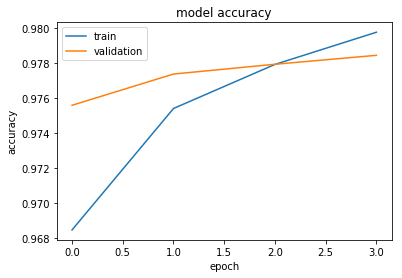

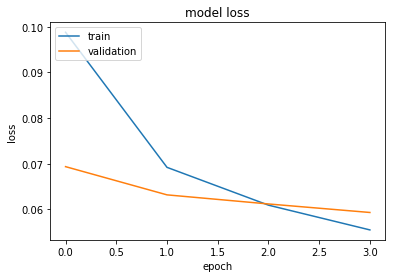

In [122]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [123]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_cnn_400_pre.h5")
print("Saved model to disk")

Saved model to disk


# Menggunakan 400 Dimensi Glove (tanpa pre)

In [62]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 61961 samples, validate on 6885 samples
Epoch 1/4
61961/61961 [==============================] - 72s 1ms/step - loss: 0.1070 - acc: 0.9667 - val_loss: 0.0733 - val_acc: 0.9741
Epoch 2/4
61961/61961 [==============================] - 72s 1ms/step - loss: 0.0724 - acc: 0.9743 - val_loss: 0.0648 - val_acc: 0.9765
Epoch 3/4
61961/61961 [==============================] - 73s 1ms/step - loss: 0.0627 - acc: 0.9772 - val_loss: 0.0614 - val_acc: 0.9776
Epoch 4/4
61961/61961 [==============================] - 72s 1ms/step - loss: 0.0570 - acc: 0.9792 - val_loss: 0.0600 - val_acc: 0.9780s -  - ETA: 0s - loss: 0.056


In [63]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 97.79%


In [64]:
scores = model.evaluate(X_train, Y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 98.31%


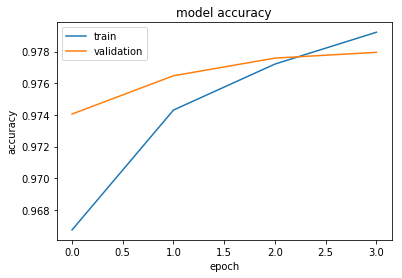

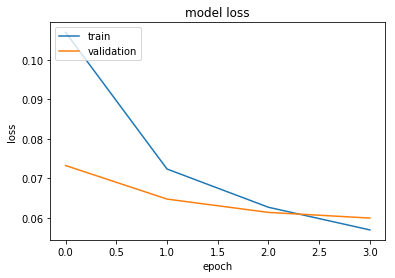

In [65]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [66]:
new_complaint = "aspal berlubang di keputih"
pad = maketoint(new_complaint)
pad=[pad]
padded = pad_sequences(pad, maxlen=53)
pred = model.predict(padded)
print(pred, column[np.argmax(pred)])

[[3.0926461e-04 1.3185250e-04 4.9235747e-04 9.5837044e-05 1.6845418e-04
  2.9863913e-05 3.8770479e-05 9.7985965e-01 8.7152846e-05 9.8556040e-05
  1.2544816e-04 4.2904879e-04 4.6216175e-03 4.9014172e-05 7.4370524e-05
  6.0389484e-03 3.2021064e-05 3.9574425e-05 4.5008954e-05 2.6608495e-05
  4.5980836e-05 1.1135361e-04 1.4247880e-05 1.3130244e-03 5.7219383e-03]] Infrastruktur


In [67]:
new_complaint = "bis membuat jalan macet"
pad = maketoint(new_complaint)
pad=[pad]
padded = pad_sequences(pad, maxlen=53)
pred = model.predict(padded)
print(pred, column[np.argmax(pred)])

[[5.31468948e-04 2.74727284e-03 1.22004334e-04 1.67743492e-04
  1.18316078e-04 8.13513543e-05 1.06728077e-03 3.20737123e-01
  6.60092919e-04 2.69182550e-04 1.43240861e-04 1.35699031e-03
  1.35470768e-02 4.09835397e-04 5.67478186e-04 5.63358247e-01
  5.98980405e-04 4.76089801e-04 3.20942869e-04 1.26041021e-04
  3.87954409e-04 5.08669589e-04 4.47569444e-04 1.65457018e-02
  7.47033581e-02]] Perhubungan


In [69]:
new_complaint = "beras rakyat miskin tidak dibgikan secara merata oleh pemerintah daerah"
pad = maketoint(new_complaint)
pad=[pad]
padded = pad_sequences(pad, maxlen=53)
pred = model.predict(padded)
print(pred, column[np.argmax(pred)])

[[3.2818261e-05 4.8027272e-05 4.6798475e-03 2.8259206e-05 9.9252957e-01
  5.2407154e-06 6.7201978e-07 4.7439316e-05 9.5814294e-06 8.1663829e-06
  1.7914539e-03 1.5327685e-04 1.3880212e-04 8.8692523e-06 4.1420582e-05
  2.7267450e-05 1.5225463e-05 1.0274706e-05 4.2466272e-06 6.2011765e-07
  4.5521351e-06 7.9605888e-06 8.5935299e-06 1.4297060e-04 2.5480703e-04]] Beras Miskin (Raskin)


In [70]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_cnn_400.h5")
print("Saved model to disk")

Saved model to disk


In [29]:
filters = 250
kernel_size = 3
hidden_dims = 250

model = Sequential()
model.add(Embedding(input_dim = len(vocabulary)+1, # size of the vocabulary, len( a matrix) will 
        output_dim = 50, # 
        weights= [embed], # there is not weights in Embedding api
        input_length=X.shape[1]))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(25))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

epochs = 4
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 61961 samples, validate on 6885 samples
Epoch 1/4
61961/61961 [==============================] - 7s 121us/step - loss: 1.3096 - acc: 0.5915 - val_loss: 1.1615 - val_acc: 0.6177
Epoch 2/4
61961/61961 [==============================] - 4s 72us/step - loss: 0.9456 - acc: 0.6901 - val_loss: 0.9579 - val_acc: 0.6937
Epoch 3/4
61961/61961 [==============================] - 4s 72us/step - loss: 0.8509 - acc: 0.7182 - val_loss: 0.9648 - val_acc: 0.6903
Epoch 4/4
61961/61961 [==============================] - 5s 73us/step - loss: 0.7826 - acc: 0.7381 - val_loss: 1.0114 - val_acc: 0.6844


In [30]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 68.31%


In [31]:
scores = model.evaluate(X_train, Y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 73.83%


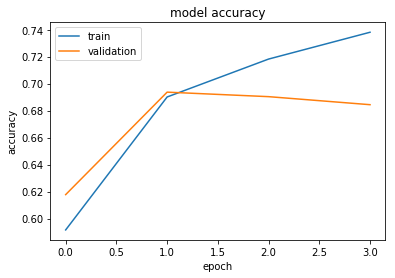

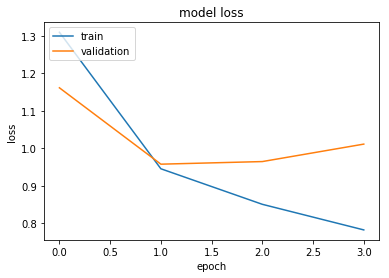

In [32]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_cnn_400.h5")
print("Saved model to disk")